In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import binned_statistic_2d
import sys
import uproot
import plotly.graph_objects as go

import torch
import torch_geometric
from torch_geometric.loader import DataLoader
sys.path.append('/sps/t2k/cehrhardt/analysis_tools/tools')

from analysis_tools.tools.old import decompose_vector, cartesian_to_cylindrical, cartesian_to_cylindrical_batch, vector_projection, project_to_new_basis, project_to_new_basis_batch
from test_GCN.utils import train, Normalize
from dataset_from_processed import DatasetFromProcessed

## Load the data

In [10]:
#for the run
run_path="/sps/t2k/cehrhardt/Caverns/WatChMaL/outputs/2024-06-27/04-58-20"
graph_folder_path = '/sps/t2k/cehrhardt/dataset/graph_1.5M_hitxyztc_t_xyzt_r12'

#for the direction
root_file_path='/sps/t2k/lperisse/Soft/wcsim/results/electron/wcsim112_UnifVtx_electron_HK_10MeV_WINDOWS.root'
# root_file_path='/sps/t2k/lperisse/Soft/wcsim/results/electron/wcsim112_UnifVtx_electron_HK_10MeV_1Mevents_WINDOWS.root'

feat_max = [3250, 3250, 3300, 500, 420]
feat_min = [-3250, -3250, -3300, -600, 0]

label_max = [3250, 3250, 3300, 250]
label_min = [-3250, -3250, -3300, -1200]

# feat_max = [3250, 3250, 3300, 450, 15]
# feat_min = [-3250, -3250, -3300, -400, 0]

# label_max = [2600, 3250, 3250, -20]
# label_min = [-2650, -3000, -3000, -200]

test_batch_size = 5000

In [11]:
#Normalization
transform = torch_geometric.transforms.Compose([Normalize(feat_norm=[feat_max,feat_min], label_norm=[label_max, label_min])])

#Load the graph
dataset = DatasetFromProcessed(graph_folder_path = graph_folder_path, graph_file_names = ['data.pt'],  verbose = 1)


#Get the result of the run
index_list = np.load(run_path+"/indices.npy")
predictions = np.load(run_path+"/preds.npy")

#Load the test data to compare 
sampled_data = dataset[index_list]
true_loader = DataLoader(sampled_data, batch_size=test_batch_size, shuffle=False)

To run to load the direction for resolution plots

In [4]:
root_file = uproot.open(root_file_path)
# print(root_file['THits'].keys())
direction_x = root_file['THits']['direction_x'].arrays()
direction_y = root_file['THits']['direction_y'].arrays()
direction_z = root_file['THits']['direction_z'].arrays()

sampled_dir_x = direction_x[index_list]
dir_x = [item['direction_x'] for item in sampled_dir_x]
sampled_dir_y = direction_y[index_list]
dir_y = [item['direction_y'] for item in sampled_dir_y]
sampled_dir_z = direction_z[index_list]
dir_z = [item['direction_z'] for item in sampled_dir_z]

direction = np.stack((dir_x, dir_y, dir_z), axis=-1)

## Compute resolution

Loops to compute the resolution at the 68% percentile for the absolute difference in norm, projection on perpendicular and parallel direction, time and credible interval of time difference.

### Position and time

In [12]:
norm_pos_all=np.array([])
norm_time_all=np.array([])
norm_time_abs_all=np.array([])
norm_pos_p_all=np.array([])
norm_pos_o_all=np.array([])

for true_data, predict_data in zip(true_loader, predictions):

    true = np.array([true_data.y])
    true = true.reshape(test_batch_size,4)

    predict = predict_data * (np.array(label_max) - np.array(label_min)) + np.array(label_min) #eps=1e-12 neglected
    
    predict_vtx = predict[:,:3]
    true_vtx = true[:,:3]
    
    norm_pos = predict_vtx - true_vtx
    norm_pos = np.linalg.norm(norm_pos, ord=2, axis=1)  # Compute sqrt(x^2 + y^2 + z^2) for each event

    norm_time = predict[:,3] - true[:,3]
    norm_time_abs = np.abs(norm_time)  # Compute absolute value

    norm_pos_all=np.append(norm_pos_all, norm_pos)
    norm_time_all=np.append(norm_time_all, norm_time)
    norm_time_abs_all=np.append(norm_time_abs_all, norm_time_abs)

res_time = np.quantile(norm_time_abs_all, 0.68, axis=0)
cred_int = np.quantile(norm_time_all, 0.16, axis=0), np.quantile(norm_time_all, 0.84, axis=0)
res_pos = np.quantile(norm_pos_all, 0.68, axis=0)

print(f"Resolution at 68% for:\n- on the position norm: {res_pos:.2f} cm \n- on time: {res_time:.2f} ns\nCredible interval on time at 68%: {cred_int[0]:.2f} ns to {cred_int[1]:.2f} ns")

Resolution at 68% for:
- on the position norm: 160.13 cm 
- on time: 4.94 ns
Credible interval on time at 68%: -5.18 ns to 4.64 ns


### Position, direction and time

In [5]:
norm_pos_all=np.array([])
norm_time_all=np.array([])
norm_time_abs_all=np.array([])
norm_pos_p_all=np.array([])
norm_pos_o_all=np.array([])

for true_data, predict_data, dir in zip(true_loader, predictions, direction):

    true=np.array([true_data.y])
    true = true.reshape(test_batch_size,4)

    predict = predict_data * (np.array(label_max) - np.array(label_min)) + np.array(label_min) #eps=1e-12 neglected
    
    predict_vtx = predict[:,:3]
    true_vtx = true[:,:3]
    
    norm_pos = predict_vtx - true_vtx
    norm_pos = np.linalg.norm(norm_pos, ord=2, axis=1)  # Compute sqrt(x^2 + y^2 + z^2) for each event

    norm_time = predict[:,3] - true[:,3]
    norm_time_abs = np.abs(norm_time)  # Compute absolute value

    norm_pos_all=np.append(norm_pos_all, norm_pos)
    norm_time_all=np.append(norm_time_all, norm_time)
    norm_time_abs_all=np.append(norm_time_abs_all, norm_time_abs)


    true_para, true_ortho = decompose_vector(true_vtx, dir)
    
    predict_para, predict_ortho = decompose_vector(predict_vtx, dir)
    
    norm_pos_p = predict_para - true_para
    norm_pos_p = np.linalg.norm(norm_pos_p, ord=2, axis=1)  # Compute sqrt(x^2 + y^2 + z^2) for each batch
    norm_pos_p_all=np.append(norm_pos_p_all, norm_pos_p)

    norm_pos_o = predict_ortho - true_ortho
    norm_pos_o = np.linalg.norm(norm_pos_o, ord=2, axis=1)  # Compute sqrt(x^2 + y^2 + z^2) for each batch
    norm_pos_o_all=np.append(norm_pos_o_all, norm_pos_o)

res_time = np.quantile(norm_time_abs_all, 0.68, axis=0)
cred_int = np.quantile(norm_time_all, 0.16, axis=0), np.quantile(norm_time_all, 0.84, axis=0)
res_pos = np.quantile(norm_pos_all, 0.68, axis=0)
res_pos_para = np.quantile(norm_pos_p_all, 0.68, axis=0)
res_pos_ortho = np.quantile(norm_pos_o_all, 0.68, axis=0)
check = np.sqrt(res_pos_para**2 + res_pos_ortho**2)

print(f"Resolution at 68% for:\n- on the position norm: {res_pos:.2f} cm \n- on the direction projection: {res_pos_para:.2f} cm\n- orthogonal to the direction projection: {res_pos_ortho:.2f} cm\n- on time: {res_time:.2f} ns\nCredible interval on time at 68%: {cred_int[0]:.2f} ns to {cred_int[1]:.2f} ns")

Resolution at 68% for:
- on the position norm: 196.27 cm 
- on the direction projection: 119.08 cm
- orthogonal to the direction projection: 135.29 cm
- on time: 5.73 ns
Credible interval on time at 68%: -5.22 ns to 6.23 ns


### Position and direction projection

In [30]:
norm_pos_all=np.array([])
norm_pos_p_all=np.array([])
norm_pos_o_all=np.array([])

for true_data, predict_data, dir in zip(true_loader, predictions, direction):

    true_vtx = np.array([true_data.y])
    true_vtx = true_vtx.reshape(test_batch_size,4)[:,0:3]

    predict_vtx = predict_data * (np.array(label_max) - np.array(label_min)) + np.array(label_min) #eps=1e-12 neglected
    predict_vtx = predict_vtx [:,0:3]

    norm_pos = predict_vtx - true_vtx
    norm_pos = np.linalg.norm(norm_pos, ord=2, axis=1)  # Compute sqrt(x^2 + y^2 + z^2) for each batch
    norm_pos_all=np.append(norm_pos_all, norm_pos)

    true_para, true_ortho = decompose_vector(true_vtx, dir)
    
    predict_para, predict_ortho = decompose_vector(predict_vtx, dir)
    
    norm_pos_p = predict_para - true_para
    norm_pos_p = np.linalg.norm(norm_pos_p, ord=2, axis=1)  # Compute sqrt(x^2 + y^2 + z^2) for each batch
    norm_pos_p_all=np.append(norm_pos_p_all, norm_pos_p)

    norm_pos_o = predict_ortho - true_ortho
    norm_pos_o = np.linalg.norm(norm_pos_o, ord=2, axis=1)  # Compute sqrt(x^2 + y^2 + z^2) for each batch
    norm_pos_o_all=np.append(norm_pos_o_all, norm_pos_o)

res_pos = np.quantile(norm_pos_all, 0.68, axis=0)
res_pos_para = np.quantile(norm_pos_p_all, 0.68, axis=0)
res_pos_ortho = np.quantile(norm_pos_o_all, 0.68, axis=0)

print(f"Resolution at 68% for:\n- on the position norm: {res_pos:.2f} cm \n- on the direction projection: {res_pos_para:.2f} cm\n- orthogonal to the direction projection: {res_pos_ortho:.2f} cm")

Resolution at 68% for:
- on the position norm: 196.27 cm 
- on the direction projection: 119.08 cm
- orthogonal to the direction projection: 135.29 cm


### Time only

In [33]:
norm_time_all=np.array([])
norm_time_abs_all=np.array([])

for true_data, predict_data in zip(true_loader, predictions):

    true = np.array([true_data.y])
    true = true.reshape(test_batch_size,4)

    predict = predict_data * (np.array(label_max) - np.array(label_min)) + np.array(label_min) #eps=1e-12 neglected

    norm_time = predict[:,3] - true[:,3]
    norm_time_abs = np.abs(norm_time) 

    norm_time_all=np.append(norm_time_all, norm_time)
    norm_time_abs_all=np.append(norm_time_abs_all, norm_time_abs)

res_time = np.quantile(norm_time_abs_all, 0.68, axis=0)
cred_int = np.quantile(norm_time_all, 0.16, axis=0), np.quantile(norm_time, 0.84, axis=0)

print(f"Resolution at 68% for time: {res_time:.2f} ns\n Credible interval 68%: {cred_int[0]:.2f} ns to {cred_int[1]:.2f} ns")

Resolution at 68% for time: 5.73 ns
 Credible interval 68%: -5.22 ns to 6.05 ns


## Plots

### 1D histogram

Text(0.5, 1.0, 'Histogram of the vertex position reconstruction resolution')

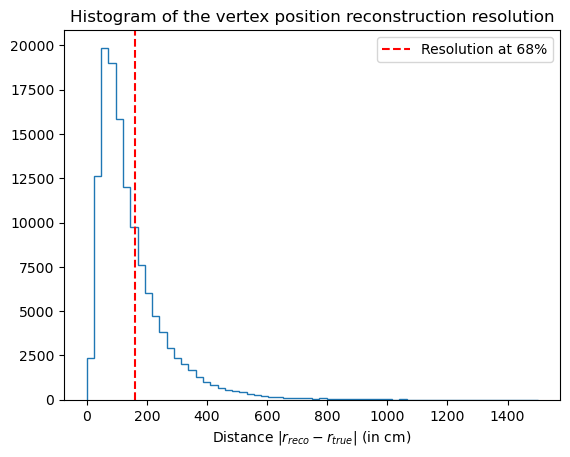

In [13]:
bin_edges = np.linspace(-1, 1500, 63)

plt.hist(norm_pos_all, bins=bin_edges, histtype='step')
# plt.hist(norm_pos_all, bins=62, histtype='step')

plt.axvline(x=res_pos, color='r', linestyle='--', linewidth=1.5, label='Resolution at 68%')

plt.legend()
plt.xlabel('Distance $|r_{reco} - r_{true}|$ (in cm)')
plt.title('Histogram of the vertex position reconstruction resolution')

Text(0.5, 1.0, 'Histogram of the vertex position reconstruction resolution')

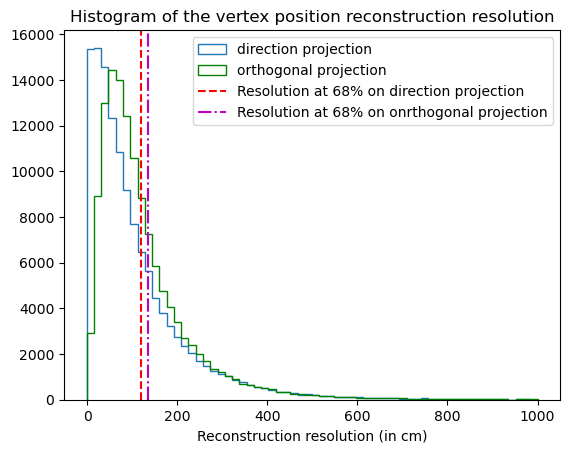

In [7]:
# plt.figure(figsize=(10, 6))

bin_edges = np.linspace(-1, 1000, 63)

plt.hist(norm_pos_p_all, bins=bin_edges, histtype='step', label='direction projection')
plt.hist(norm_pos_o_all, bins=bin_edges, histtype='step', label='orthogonal projection', color='g')

plt.axvline(x=res_pos_para, color='r', linestyle='--', linewidth=1.5, label='Resolution at 68% on direction projection')
plt.axvline(x=res_pos_ortho, color='m', linestyle='dashdot', linewidth=1.5, label='Resolution at 68% on onrthogonal projection')

plt.legend(loc='upper right')
plt.xlabel('Reconstruction resolution (in cm)')
plt.title('Histogram of the vertex position reconstruction resolution')

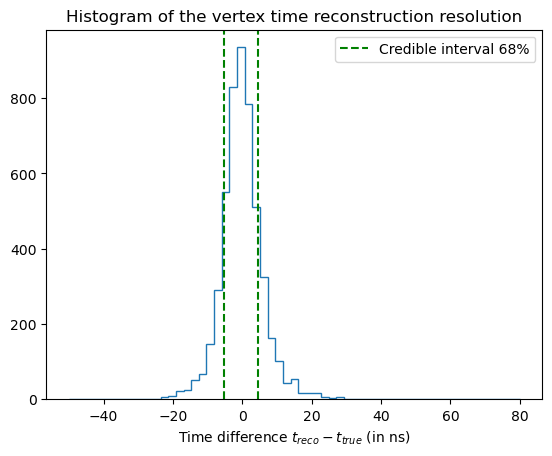

In [14]:
# plt.hist(norm_time_all, bins=70, histtype='step')
bin_edges = np.linspace(-50, 80, 60)
plt.hist(norm_time[(norm_time<200) & (norm_time>-100)], bins=bin_edges, histtype='step')

# plt.axvline(x=res_time, color='r', linestyle='--', linewidth=1.5, label='Resolution at 68%')


plt.axvline(x=cred_int[0], color='g', linestyle='--', linewidth=1.5, label='Credible interval 68%')
plt.axvline(x=cred_int[1], color='g', linestyle='--', linewidth=1.5)

plt.legend()

plt.xlabel('Time difference $t_{reco} - t_{true}$ (in ns)')
plt.title('Histogram of the vertex time reconstruction resolution')

plt.show()

### 2D histogram

#### Time resolution (predicted vs true)

Here it computes the data : 

In [9]:
time_distrib_true = np.array([])
time_distrib_predict = np.array([])
for true_data, predict_data in zip(true_loader, predictions):

        true=np.array([true_data.y])
        true = true.reshape(test_batch_size,4)

        predict = predict_data * (np.array(label_max) - np.array(label_min)) + np.array(label_min)

        time_distrib_true=np.append(time_distrib_true, true[:,3])
        time_distrib_predict=np.append(time_distrib_predict, predict[:,3])

Here it creates the plot : 

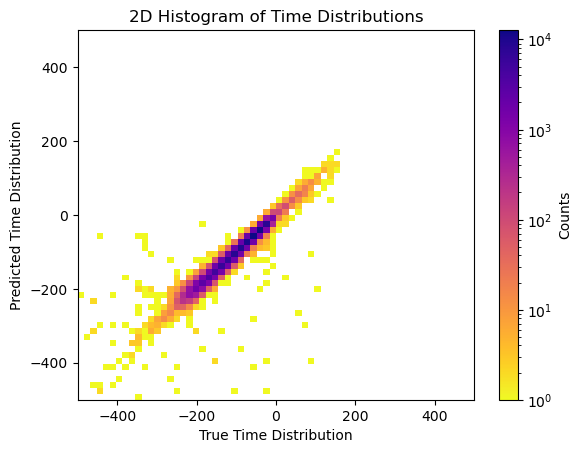

In [10]:
bin_edges = np.linspace(-500, 500, 63)

# Create a 2D histogram with logarithmic normalization
plt.hist2d(time_distrib_true, time_distrib_predict, bins=(bin_edges, bin_edges), cmap='plasma_r', norm=mcolors.LogNorm())

# Add labels and title
plt.xlabel('True Time Distribution')
plt.ylabel('Predicted Time Distribution')
plt.title('2D Histogram of Time Distributions')

# Add colorbar
plt.colorbar(label='Counts')

# Show plot
plt.show()

#### To wall/to center resolution

Here it computes the data : 

In [11]:
rad_towall_pos_distrib = np.array([])
z_towall_pos_distrib = np.array([])

rad_tocenter_pos_distrib = np.array([])
z_tocenter_pos_distrib = np.array([])

norm_pos_towall_all = np.array([])
norm_pos_tocenter_all = np.array([])

norm_pos_all = np.array([])

for true_data, predict_data, dir in zip(true_loader, predictions, direction):

    true_vtx = np.array([true_data.y]).reshape(test_batch_size, 4)
    predict_vtx = predict_data * (np.array(label_max) - np.array(label_min)) + np.array(label_min)  # eps=1e-12 négligé

    norm_pos = np.linalg.norm(predict_vtx[:, :3] - true_vtx[:, :3], ord=2, axis=1)  # Calcul de sqrt(x^2 + y^2 + z^2)
    
    rad_pos_distrib = np.linalg.norm(true_vtx[:, :2], ord=2, axis=1)
    z_pos_distrib = true_vtx[:, 2]

    ##towall/tocenter distinction
    cylindrical_vtx = cartesian_to_cylindrical_batch(true_vtx)

    r = cylindrical_vtx[:, 0]
    theta = cylindrical_vtx[:, 1]
    z_cyl = cylindrical_vtx[:, 2]

    r_hat = np.column_stack((np.cos(theta), np.sin(theta), np.zeros_like(theta)))
    theta_hat = np.column_stack((-np.sin(theta), np.cos(theta), np.zeros_like(theta)))
    z_hat = np.column_stack((np.zeros_like(z_cyl), np.zeros_like(z_cyl), np.ones_like(z_cyl)))

    new_basis = np.array([r_hat, theta_hat, z_hat]).transpose(1, 0, 2)

    dir_proj = project_to_new_basis_batch(dir, new_basis)

    #all appends
    rad_towall_distrib = rad_pos_distrib[dir_proj[:,0] >= 0]
    z_towall_distrib = z_pos_distrib[dir_proj[:,0] >= 0]
    norm_pos_towall = norm_pos[dir_proj[:,0] >= 0]

    rad_towall_pos_distrib = np.append(rad_towall_pos_distrib, rad_towall_distrib)
    z_towall_pos_distrib = np.append(z_towall_pos_distrib, z_towall_distrib)
    norm_pos_towall_all = np.append(norm_pos_towall_all, norm_pos_towall)

    rad_tocenter_distrib =  rad_pos_distrib[dir_proj[:,0] < 0]
    z_tocenter_distrib =  z_pos_distrib[dir_proj[:,0] < 0]
    norm_pos_tocenter = norm_pos[dir_proj[:,0] < 0]

    rad_tocenter_pos_distrib = np.append(rad_tocenter_pos_distrib, rad_tocenter_distrib)
    z_tocenter_pos_distrib = np.append(z_tocenter_pos_distrib, z_tocenter_distrib)
    norm_pos_tocenter_all = np.append(norm_pos_tocenter_all, norm_pos_tocenter)

Here it does the plots for the resolution of events going toward the wall : 

In [26]:
print(np.nanmin(percentile_matrix))
print(np.nanmax(percentile_matrix))

76.44369019051891
724.0695196867509


In [21]:
val_min = 50 
val_max = 750

Text(0.5, 1.0, 'Spatial Resolution (68th Percentile) for toward wall')

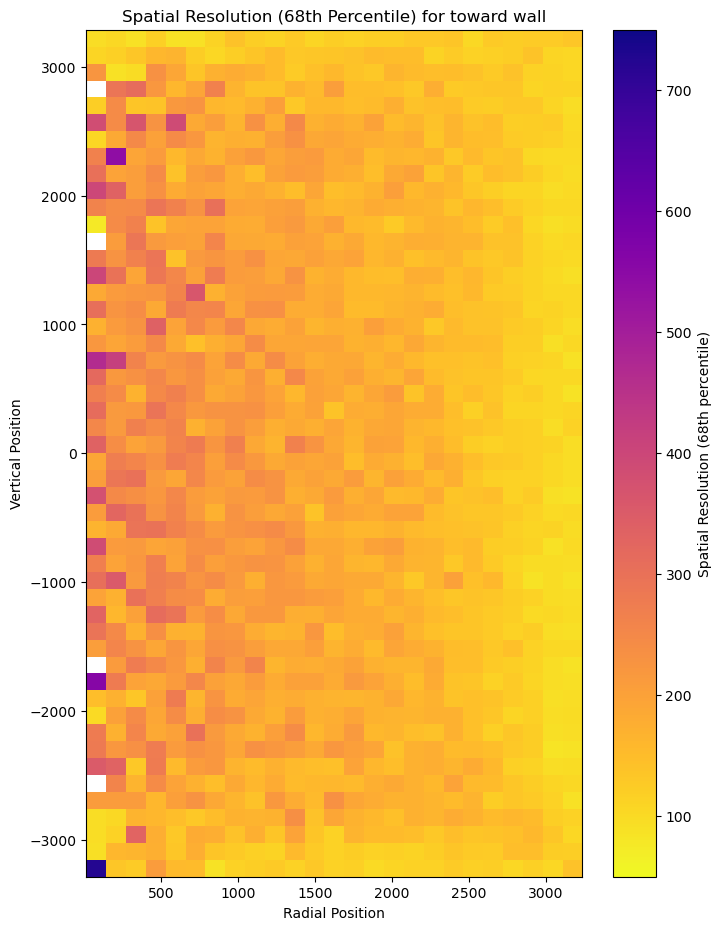

In [25]:
num_rad_bins = 25
num_z_bins = 50
rad_bin_edges = np.linspace(np.min(rad_towall_pos_distrib), np.max(rad_towall_pos_distrib), num_rad_bins + 1)
z_bin_edges = np.linspace(np.min(z_towall_pos_distrib), np.max(z_towall_pos_distrib), num_z_bins + 1)

percentile_matrix = np.full((num_rad_bins, num_z_bins), np.nan)

closewall_vtx=np.array([])

# Calculer le 68ème percentile dans chaque bin
for i in range(num_rad_bins):
    for j in range(num_z_bins):
        # Sélectionner les indices des points dans le bin courant
        indices = (rad_towall_pos_distrib >= rad_bin_edges[i]) & (rad_towall_pos_distrib < rad_bin_edges[i+1]) & \
                  (z_towall_pos_distrib >= z_bin_edges[j]) & (z_towall_pos_distrib < z_bin_edges[j+1])
        
        if np.any(indices):  # Vérifier s'il y a des points dans le bin
            percentile_matrix[i, j] = np.percentile(norm_pos_towall_all[indices], 68)

        if i==4:
            closewall_vtx = np.append(closewall_vtx, norm_pos_towall_all[indices])

# Création de la figure et de l'histogramme 2D
plt.figure(figsize=(8, 11))
plt.pcolormesh(rad_bin_edges, z_bin_edges, percentile_matrix.T, cmap='plasma_r', shading='auto', vmin=val_min, vmax=val_max)
plt.colorbar(label='Spatial Resolution (68th percentile)')

# Ajouter des labels et un titre
plt.xlabel('Radial Position')
plt.ylabel('Vertical Position')
plt.title('Spatial Resolution (68th Percentile) for toward wall')

Here it does the plots for the resolution of events going toward the center : 

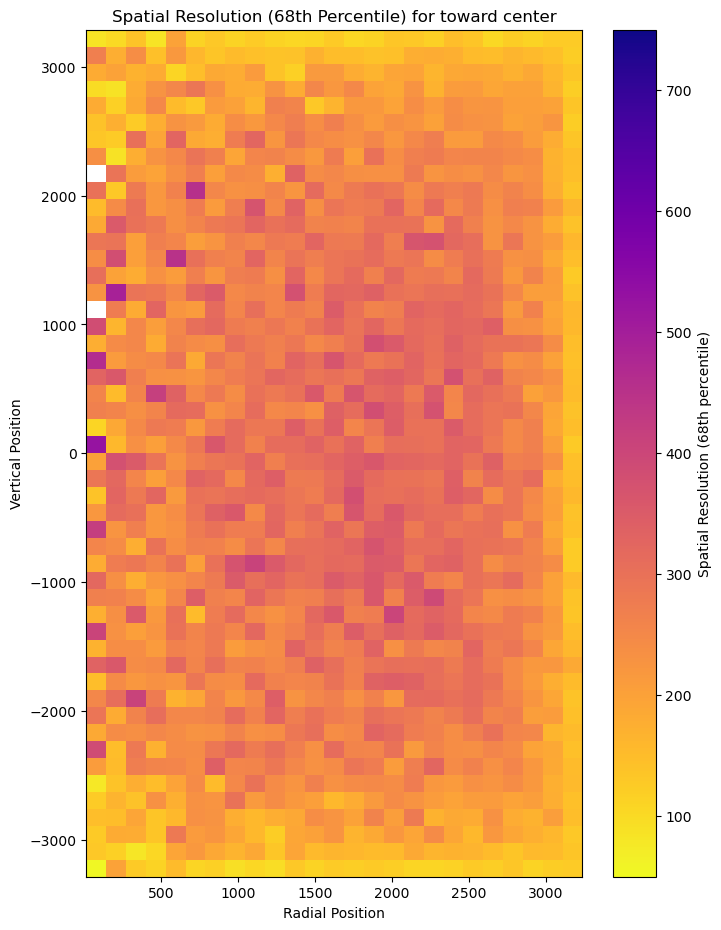

In [23]:
num_rad_bins = 25
num_z_bins = 50
rad_bin_edges = np.linspace(np.min(rad_tocenter_pos_distrib), np.max(rad_tocenter_pos_distrib), num_rad_bins + 1)
z_bin_edges = np.linspace(np.min(z_tocenter_pos_distrib), np.max(z_tocenter_pos_distrib), num_z_bins + 1)

percentile_matrix = np.full((num_rad_bins, num_z_bins), np.nan)

# Calculer le 68ème percentile dans chaque bin
for i in range(num_rad_bins):
    for j in range(num_z_bins):
        # Sélectionner les indices des points dans le bin courant
        indices = (rad_tocenter_pos_distrib >= rad_bin_edges[i]) & (rad_tocenter_pos_distrib < rad_bin_edges[i+1]) & \
                  (z_tocenter_pos_distrib >= z_bin_edges[j]) & (z_tocenter_pos_distrib < z_bin_edges[j+1])
        
        if np.any(indices):  # Vérifier s'il y a des points dans le bin
            percentile_matrix[i, j] = np.percentile(norm_pos_tocenter_all[indices], 68)

# Création de la figure et de l'histogramme 2D
plt.figure(figsize=(8, 11))
plt.pcolormesh(rad_bin_edges, z_bin_edges, percentile_matrix.T, cmap='plasma_r', shading='auto', vmin=val_min, vmax=val_max)
plt.colorbar(label='Spatial Resolution (68th percentile)')

# Ajouter des labels et un titre
plt.xlabel('Radial Position')
plt.ylabel('Vertical Position')
plt.title('Spatial Resolution (68th Percentile) for toward center')

plt.show()

#### To wall/to center and to bottom/bottom resolution

Here it computes the data : 

In [14]:
rad_wall_top_pos_distrib = np.array([])
z_wall_top_pos_distrib = np.array([])

rad_wall_bottom_pos_distrib = np.array([])
z_wall_bottom_pos_distrib = np.array([])

rad_center_top_pos_distrib = np.array([])
z_center_top_pos_distrib = np.array([])

rad_center_bottom_pos_distrib = np.array([])
z_center_bottom_pos_distrib = np.array([])

norm_pos_wall_top_all = np.array([])
norm_pos_wall_bottom_all = np.array([])
norm_pos_center_top_all = np.array([])
norm_pos_center_bottom_all = np.array([])

norm_pos_all = np.array([])

for true_data, predict_data, dir in zip(true_loader, predictions, direction):

    true_vtx = np.array([true_data.y]).reshape(test_batch_size, 4)
    predict_vtx = predict_data * (np.array(label_max) - np.array(label_min)) + np.array(label_min)  # eps=1e-12 négligé

    norm_pos = np.linalg.norm(predict_vtx[:, :3] - true_vtx[:, :3], ord=2, axis=1)  # Calcul de sqrt(x^2 + y^2 + z^2)
    
    rad_pos_distrib = np.linalg.norm(true_vtx[:, :2], ord=2, axis=1)
    z_pos_distrib = true_vtx[:, 2]

    ##towall/tocenter distinction
    cylindrical_vtx = cartesian_to_cylindrical_batch(true_vtx)

    r = cylindrical_vtx[:, 0]
    theta = cylindrical_vtx[:, 1]
    z_cyl = cylindrical_vtx[:, 2]

    r_hat = np.column_stack((np.cos(theta), np.sin(theta), np.zeros_like(theta)))
    theta_hat = np.column_stack((-np.sin(theta), np.cos(theta), np.zeros_like(theta)))
    z_hat = np.column_stack((np.zeros_like(z_cyl), np.zeros_like(z_cyl), np.ones_like(z_cyl)))

    new_basis = np.array([r_hat, theta_hat, z_hat]).transpose(1, 0, 2)

    dir_proj = project_to_new_basis_batch(dir, new_basis)

    #all appends
    rad_wall_top_distrib = rad_pos_distrib[np.logical_and(dir_proj[:,0] >= 0, dir_proj[:,2] >= 0)]
    z_wall_top_distrib = z_pos_distrib[np.logical_and(dir_proj[:,0] >= 0, dir_proj[:,2] >= 0)]
    norm_pos_wall_top = norm_pos[np.logical_and(dir_proj[:,0] >= 0, dir_proj[:,2] >= 0)]

    rad_wall_top_pos_distrib = np.append(rad_wall_top_pos_distrib, rad_wall_top_distrib)
    z_wall_top_pos_distrib = np.append(z_wall_top_pos_distrib, z_wall_top_distrib)
    norm_pos_wall_top_all = np.append(norm_pos_wall_top_all, norm_pos_wall_top)


    rad_wall_bottom_distrib = rad_pos_distrib[np.logical_and(dir_proj[:,0] >= 0, dir_proj[:,2] < 0)]
    z_wall_bottom_distrib = z_pos_distrib[np.logical_and(dir_proj[:,0] >= 0, dir_proj[:,2] < 0)]
    norm_pos_wall_bottom = norm_pos[np.logical_and(dir_proj[:,0] >= 0, dir_proj[:,2] < 0)]

    rad_wall_bottom_pos_distrib = np.append(rad_wall_bottom_pos_distrib, rad_wall_bottom_distrib)
    z_wall_bottom_pos_distrib = np.append(z_wall_bottom_pos_distrib, z_wall_bottom_distrib)
    norm_pos_wall_bottom_all = np.append(norm_pos_wall_bottom_all, norm_pos_wall_bottom)


    rad_center_top_distrib = rad_pos_distrib[np.logical_and(dir_proj[:,0] < 0, dir_proj[:,2] >= 0)]
    z_center_top_distrib = z_pos_distrib[np.logical_and(dir_proj[:,0] < 0, dir_proj[:,2] >= 0)]
    norm_pos_center_top = norm_pos[np.logical_and(dir_proj[:,0] < 0, dir_proj[:,2] >= 0)]

    rad_center_top_pos_distrib = np.append(rad_center_top_pos_distrib, rad_center_top_distrib)
    z_center_top_pos_distrib = np.append(z_center_top_pos_distrib, z_center_top_distrib)
    norm_pos_center_top_all = np.append(norm_pos_center_top_all, norm_pos_center_top)

    rad_center_bottom_distrib = rad_pos_distrib[np.logical_and(dir_proj[:,0] < 0, dir_proj[:,2] < 0)]
    z_center_bottom_distrib = z_pos_distrib[np.logical_and(dir_proj[:,0] < 0, dir_proj[:,2] < 0)]
    norm_pos_center_bottom = norm_pos[np.logical_and(dir_proj[:,0] < 0, dir_proj[:,2] < 0)]

    rad_center_bottom_pos_distrib = np.append(rad_center_bottom_pos_distrib, rad_center_bottom_distrib)
    z_center_bottom_pos_distrib = np.append(z_center_bottom_pos_distrib, z_center_bottom_distrib)
    norm_pos_center_bottom_all = np.append(norm_pos_center_bottom_all, norm_pos_center_bottom)


Here it does the plots : 

In [93]:
vmin = 10
vmax = 700

Text(0.5, 1.0, 'Spatial Resolution (68th Percentile) for to wall and to top')

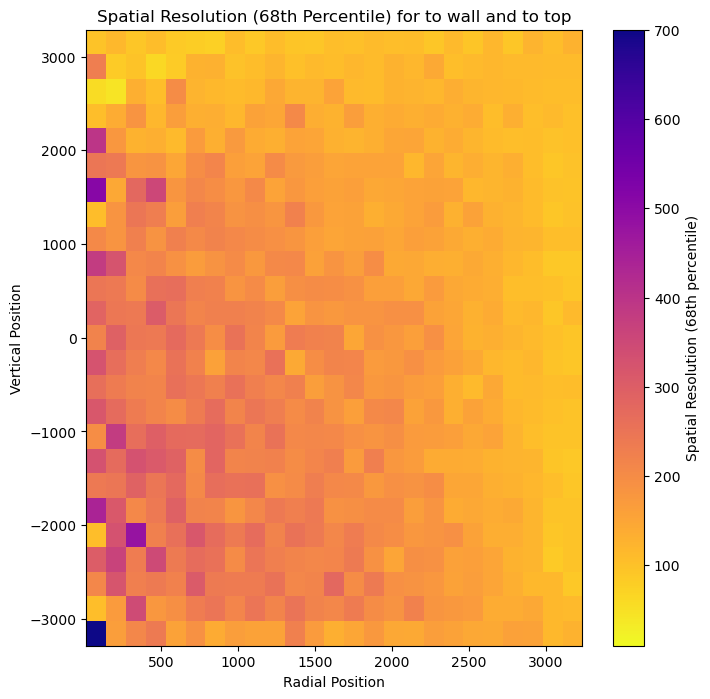

In [106]:
rad_distrib = rad_wall_top_pos_distrib
z_distrib = z_wall_top_pos_distrib
norm_pos = norm_pos_wall_top_all

num_rad_bins = 25
num_z_bins = 25
rad_bin_edges = np.linspace(np.min(rad_distrib), np.max(rad_distrib), num_rad_bins + 1)
z_bin_edges = np.linspace(np.min(z_distrib), np.max(z_distrib), num_z_bins + 1)

percentile_matrix = np.full((num_rad_bins, num_z_bins), np.nan)

closewall_vtx=np.array([])

# Calculer le 68ème percentile dans chaque bin
for i in range(num_rad_bins):
    for j in range(num_z_bins):
        # Sélectionner les indices des points dans le bin courant
        indices = (rad_distrib >= rad_bin_edges[i]) & (rad_distrib < rad_bin_edges[i+1]) & \
                  (z_distrib >= z_bin_edges[j]) & (z_distrib < z_bin_edges[j+1])
        
        if np.any(indices):  # Vérifier s'il y a des points dans le bin
            percentile_matrix[i, j] = np.percentile(norm_pos[indices], 68)

        if i==4:
            closewall_vtx = np.append(closewall_vtx, norm_pos[indices])

# Création de la figure et de l'histogramme 2D
plt.figure(figsize=(8, 8))
plt.pcolormesh(rad_bin_edges, z_bin_edges, percentile_matrix.T, cmap='plasma_r', shading='auto', vmin=vmin, vmax=vmax)
plt.colorbar(label='Spatial Resolution (68th percentile)')

# Ajouter des labels et un titre
plt.xlabel('Radial Position')
plt.ylabel('Vertical Position')
plt.title('Spatial Resolution (68th Percentile) for to wall and to top')

Text(0.5, 1.0, 'Spatial Resolution (68th Percentile) for to wall and to bottom')

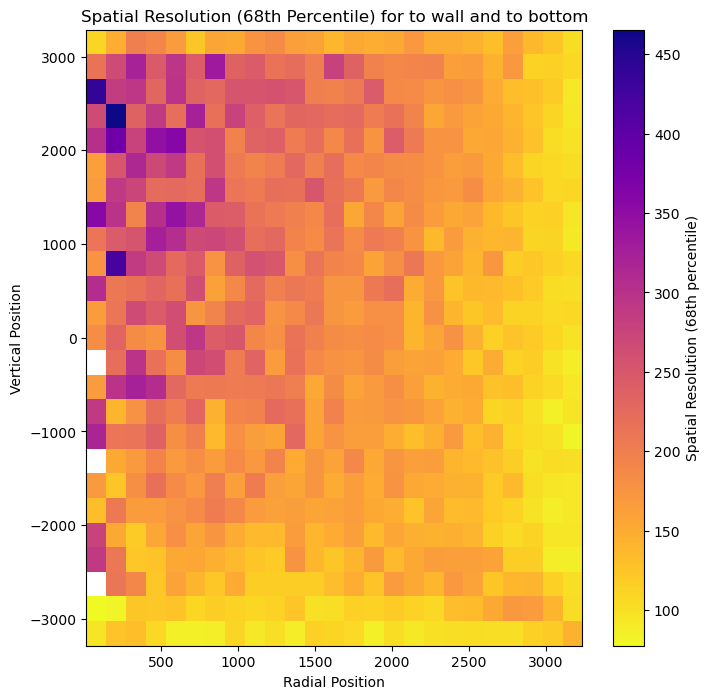

In [105]:
rad_distrib = rad_wall_bottom_pos_distrib
z_distrib = z_wall_bottom_pos_distrib
norm_pos = norm_pos_wall_bottom_all

num_rad_bins = 25
num_z_bins = 25
rad_bin_edges = np.linspace(np.min(rad_distrib), np.max(rad_distrib), num_rad_bins + 1)
z_bin_edges = np.linspace(np.min(z_distrib), np.max(z_distrib), num_z_bins + 1)

percentile_matrix = np.full((num_rad_bins, num_z_bins), np.nan)

closewall_vtx=np.array([])

# Calculer le 68ème percentile dans chaque bin
for i in range(num_rad_bins):
    for j in range(num_z_bins):
        # Sélectionner les indices des points dans le bin courant
        indices = (rad_distrib >= rad_bin_edges[i]) & (rad_distrib < rad_bin_edges[i+1]) & \
                  (z_distrib >= z_bin_edges[j]) & (z_distrib < z_bin_edges[j+1])
        
        if np.any(indices):  # Vérifier s'il y a des points dans le bin
            percentile_matrix[i, j] = np.percentile(norm_pos[indices], 68)

        if i==4:
            closewall_vtx = np.append(closewall_vtx, norm_pos[indices])

# Création de la figure et de l'histogramme 2D
plt.figure(figsize=(8, 8))
plt.pcolormesh(rad_bin_edges, z_bin_edges, percentile_matrix.T, cmap='plasma_r', shading='auto', vmin=np.nanmin(percentile_matrix), vmax=np.nanmax(percentile_matrix))
plt.colorbar(label='Spatial Resolution (68th percentile)')

# Ajouter des labels et un titre
plt.xlabel('Radial Position')
plt.ylabel('Vertical Position')
plt.title('Spatial Resolution (68th Percentile) for to wall and to bottom')

Text(0.5, 1.0, 'Spatial Resolution (68th Percentile) for to center and to top')

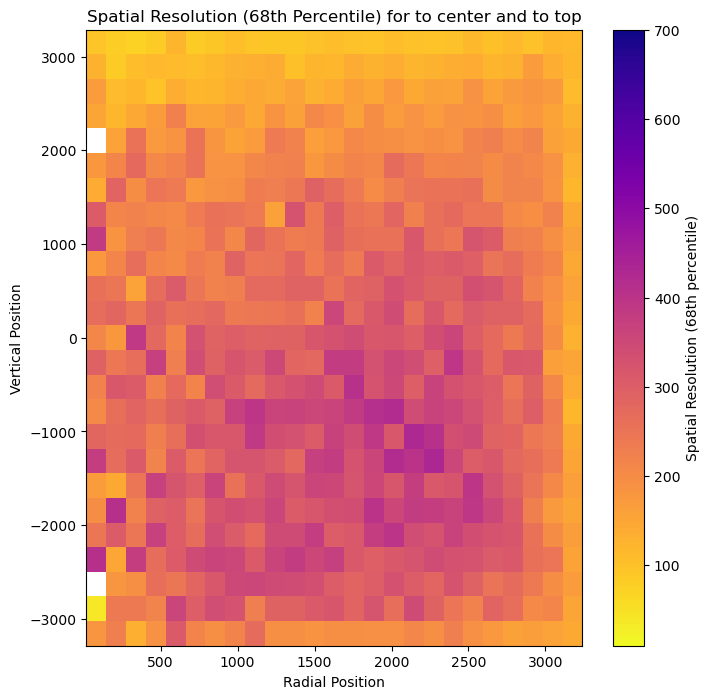

In [104]:
rad_distrib = rad_center_top_pos_distrib
z_distrib = z_center_top_pos_distrib
norm_pos = norm_pos_center_top_all

num_rad_bins = 25
num_z_bins = 25
rad_bin_edges = np.linspace(np.min(rad_distrib), np.max(rad_distrib), num_rad_bins + 1)
z_bin_edges = np.linspace(np.min(z_distrib), np.max(z_distrib), num_z_bins + 1)

percentile_matrix = np.full((num_rad_bins, num_z_bins), np.nan)

closewall_vtx=np.array([])

# Calculer le 68ème percentile dans chaque bin
for i in range(num_rad_bins):
    for j in range(num_z_bins):
        # Sélectionner les indices des points dans le bin courant
        indices = (rad_distrib >= rad_bin_edges[i]) & (rad_distrib < rad_bin_edges[i+1]) & \
                  (z_distrib >= z_bin_edges[j]) & (z_distrib < z_bin_edges[j+1])
        
        if np.any(indices):  # Vérifier s'il y a des points dans le bin
            percentile_matrix[i, j] = np.percentile(norm_pos[indices], 68)

        if i==4:
            closewall_vtx = np.append(closewall_vtx, norm_pos[indices])

# Création de la figure et de l'histogramme 2D
plt.figure(figsize=(8, 8))
plt.pcolormesh(rad_bin_edges, z_bin_edges, percentile_matrix.T, cmap='plasma_r', shading='auto', vmin=vmin, vmax=vmax)
plt.colorbar(label='Spatial Resolution (68th percentile)')

# Ajouter des labels et un titre
plt.xlabel('Radial Position')
plt.ylabel('Vertical Position')
plt.title('Spatial Resolution (68th Percentile) for to center and to top')

Text(0.5, 1.0, 'Spatial Resolution (68th Percentile) for to center and to bottom')

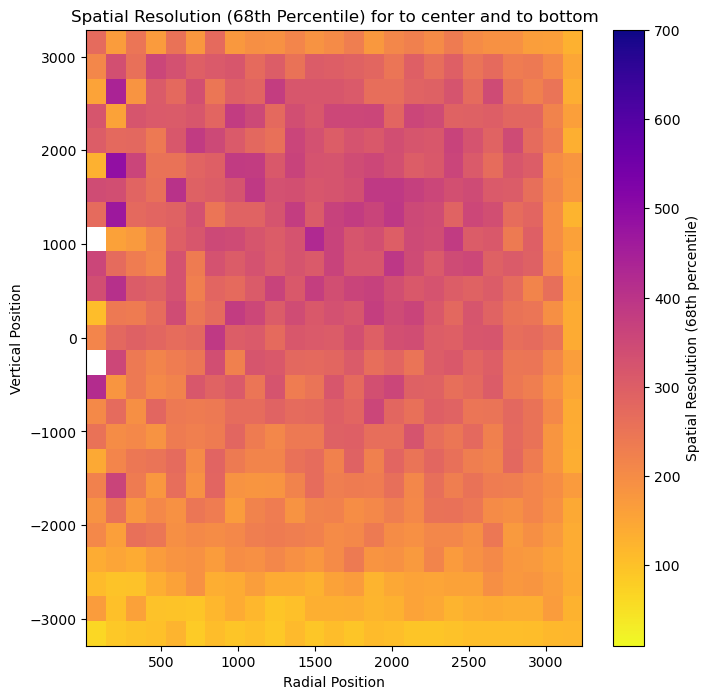

In [103]:
rad_distrib = rad_center_bottom_pos_distrib
z_distrib = z_center_bottom_pos_distrib
norm_pos = norm_pos_center_bottom_all

num_rad_bins = 25
num_z_bins = 25
rad_bin_edges = np.linspace(np.min(rad_distrib), np.max(rad_distrib), num_rad_bins + 1)
z_bin_edges = np.linspace(np.min(z_distrib), np.max(z_distrib), num_z_bins + 1)

percentile_matrix = np.full((num_rad_bins, num_z_bins), np.nan)

closewall_vtx=np.array([])

# Calculer le 68ème percentile dans chaque bin
for i in range(num_rad_bins):
    for j in range(num_z_bins):
        # Sélectionner les indices des points dans le bin courant
        indices = (rad_distrib >= rad_bin_edges[i]) & (rad_distrib < rad_bin_edges[i+1]) & \
                  (z_distrib >= z_bin_edges[j]) & (z_distrib < z_bin_edges[j+1])
        
        if np.any(indices):  # Vérifier s'il y a des points dans le bin
            percentile_matrix[i, j] = np.percentile(norm_pos[indices], 68)

        if i==4:
            closewall_vtx = np.append(closewall_vtx, norm_pos[indices])

# Création de la figure et de l'histogramme 2D
plt.figure(figsize=(8, 8))
plt.pcolormesh(rad_bin_edges, z_bin_edges, percentile_matrix.T, cmap='plasma_r', shading='auto', vmin=vmin, vmax=vmax)
plt.colorbar(label='Spatial Resolution (68th percentile)')

# Ajouter des labels et un titre
plt.xlabel('Radial Position')
plt.ylabel('Vertical Position')
plt.title('Spatial Resolution (68th Percentile) for to center and to bottom')

### 3D plot of event direction

Take the first event and project it in the basis of the direction orthogonal and parallel to the direction : 

In [67]:
event_nb=9 #btw 0 and 16384

for true_data in true_loader:
    
    true=np.array([true_data.y])
    true = true.reshape(test_batch_size,4)
    
    vtx = true[event_nb,:3]/1200

    break

x, y, z = vtx
x2, y2, z2 = direction[0,event_nb,:]

r, theta, z_cyl = cartesian_to_cylindrical(x, y, z)

r_hat = np.array([np.cos(theta), np.sin(theta), 0]) 
theta_hat = np.array([-np.sin(theta), np.cos(theta), 0])
z_hat = np.array([0, 0, 1])

new_basis=np.array([r_hat, theta_hat, z_hat])

dir_proj_good = project_to_new_basis(direction[0,event_nb,:], new_basis)


# dir_proj = vector_projection(direction[0,nb,:], r_hat)
print(dir_proj_good)
if dir_proj_good[0] > 0 : 
    print("Going toward the wall")

if dir_proj_good[0] < 0 : 
    print("Going toward the center")

[ 0.27700926 -0.8126242  -0.51274526]
Going toward the wall


Plot the event, it's direction and it's projection in its local basis : 

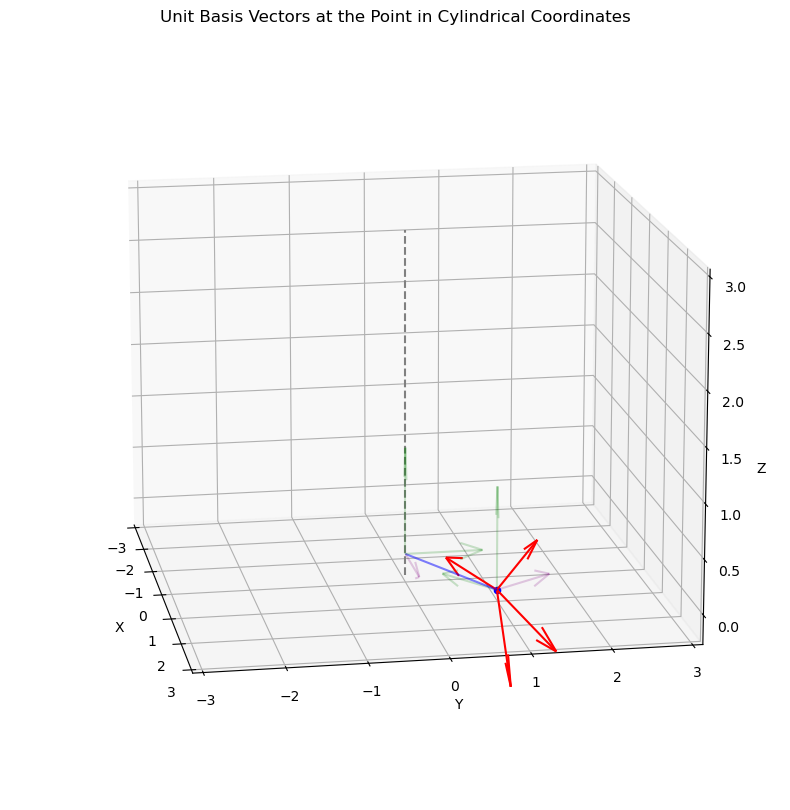

In [68]:
# Plotting
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the original Cartesian vector
ax.quiver(0, 0, 0, x, y, z, color='b', arrow_length_ratio=0.01, alpha=0.5)
ax.scatter( x, y, z, color='b', label='Vertex')
ax.quiver(x, y, z, x2, y2, z2, color='r', label='Direction Vector')
ax.quiver(x, y, z, dir_proj[0], dir_proj[1], dir_proj[2], color='r', label='Projected direction Vector')

# Plot the unit basis vectors at the translated position
ax.quiver(0, 0, 0, 1, 0, 0, color='purple', alpha=0.2)
ax.quiver(0, 0, 0, 0, 1, 0, color='g', alpha=0.2)
ax.quiver(0, 0, 0, 0, 0, 1, color='g', alpha=0.2)

ax.quiver(x, y, z, r_hat[0], r_hat[1], r_hat[2], color='purple', label='r unit vector', alpha=0.2)
ax.quiver(x, y, z, theta_hat[0], theta_hat[1], theta_hat[2], color='g', label='theta unit vector', alpha=0.2)
ax.quiver(x, y, z, z_hat[0], z_hat[1], z_hat[2], color='g', label='z unit vector', alpha=0.2)

z_axis = np.linspace(-0.2, 3, 10)  # Change the range as needed
ax.plot(0 * z_axis, 0 * z_axis, z_axis, color='grey', label='central axis of the cylinder', linestyle='dashed')

ax.view_init(elev=15, azim=-10)
max_range = 3
# max_range = np.array([x2-x, y2-y, z2-z]).max() * 1
ax.set_xlim([-max_range, max_range])
ax.set_ylim([-max_range, max_range])
ax.set_zlim([-0.2, max_range])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.legend(loc='lower right')
plt.title('Unit Basis Vectors at the Point in Cylindrical Coordinates')
plt.show()

In [74]:
max_range = 3
fig = go.Figure()

# Add the original Cartesian vector
fig.add_trace(go.Scatter3d(
    x=[0, x], y=[0, y], z=[0, z],
    mode='lines+markers',
    marker=dict(size=4, color='blue'),
    line=dict(color='blue', width=5),
    name='Original Cartesian Vector'
))

fig.add_trace(go.Scatter3d(
    x=[x], y=[y], z=[z],
    mode='markers',
    marker=dict(size=6, color='blue'),
    name='Vertex'
))

fig.add_trace(go.Scatter3d(
    x=[x, x2], y=[y, y2], z=[z, z2],
    mode='lines',
    line=dict(color='red', width=5),
    name='Direction Vector'
))

fig.add_trace(go.Scatter3d(
    x=[x, dir_proj[0]], y=[y, dir_proj[1]], z=[z, dir_proj[2]],
    mode='lines',
    line=dict(color='red', width=5, dash='dash'),
    name='Projected Direction Vector'
))

# Plot the unit basis vectors at the translated position
fig.add_trace(go.Scatter3d(
    x=[0, 1], y=[0, 0], z=[0, 0],
    mode='lines',
    line=dict(color='purple', width=2, dash='dash'),
    name='Unit X Basis Vector'
))

fig.add_trace(go.Scatter3d(
    x=[0, 0], y=[0, 1], z=[0, 0],
    mode='lines',
    line=dict(color='green', width=2, dash='dash'),
    name='Unit Y Basis Vector'
))

fig.add_trace(go.Scatter3d(
    x=[0, 0], y=[0, 0], z=[0, 1],
    mode='lines',
    line=dict(color='green', width=2, dash='dash'),
    name='Unit Z Basis Vector'
))

fig.add_trace(go.Scatter3d(
    x=[x, r_hat[0]], y=[y, r_hat[1]], z=[z, r_hat[2]],
    mode='lines',
    line=dict(color='purple', width=2, dash='dash'),
    name='r unit vector'
))

fig.add_trace(go.Scatter3d(
    x=[x, theta_hat[0]], y=[y, theta_hat[1]], z=[z, theta_hat[2]],
    mode='lines',
    line=dict(color='green', width=2, dash='dash'),
    name='theta unit vector'
))

fig.add_trace(go.Scatter3d(
    x=[x, z_hat[0]], y=[y, z_hat[1]], z=[z, z_hat[2]],
    mode='lines',
    line=dict(color='green', width=2, dash='dash'),
    name='z unit vector'
))

# Central axis of the cylinder
z_axis = np.linspace(-max_range, max_range, 10)
fig.add_trace(go.Scatter3d(
    x=[0]*len(z_axis), y=[0]*len(z_axis), z=z_axis,
    mode='lines',
    line=dict(color='grey', width=2, dash='dash'),
    name='Central Axis of the Cylinder'
))

# Set the view and axis properties
fig.update_layout(
    scene=dict(
        xaxis=dict(nticks=4, range=[-max_range, max_range], title='X'),
        yaxis=dict(nticks=4, range=[-max_range, max_range], title='Y'),
        zaxis=dict(nticks=4, range=[-max_range, max_range], title='Z'),
        aspectratio=dict(x=1, y=1, z=1)
    ),
    title='Unit Basis Vectors at the Point in Cylindrical Coordinates',
    legend=dict(x=0, y=1)
)

# Set the camera view
fig.update_layout(
    scene_camera=dict(
        eye=dict(x=1, y=-1, z=0.5)
    )
)

fig.show()
